# The Battle of the Neighborhoods  
   
## Introduction
Pakistan being a developing country has limited resources and provides limited opportunities of employment to young people. As a result, people tend to migrate to developed countries in search of employment or business opportunities. This leads to an increase in the negative migration rate (reference: https://www.indexmundi.com/pakistan/net_migration_rate.html), which means that more people are migrating to other countries every year. Now, young entrepreneurs who are interested in opening up their own businesses abroad, struggle a lot and waste a lot of resources trying to research and understand the new market in order to make better business decisions. They need to have a working method to assist them in making better investment decisions without spending huge loads of money at the start on market research.

## 1. Business Problem
One of the most appealing destinations for young entrepreneurs is London(United Kingdom) because of its multi-cultural and diverse audience. London also has been a popular tourist destination for the past few decades, which makes it a dream city for businesses who want to reach a larger audience. So our business problem will be based on London. We want to assist an entrepreneur who wants to start a Pakistani restaurant in London. Instead of spending money on market research through agencies or by herself and taking huge risk with her investment even after market research, she wants to know which would be the most suitable area to open a Pakistani restaurant in London? This would help her understand the population of different areas of London and location of different types of restaurants, and based on the analysis she can make better decision on where to open a Pakistani restaurant which would be profitable.  
Any entrepreneur from Pakistan would be interested in this project, since it'll assist them in making better investment decisions and saving them good amount of market research costs.

## 2. Data
To solve our business problem, we'll need data about the areas of London and the types of restaurants across the different areas of London. We'll use the 'list of areas of London' from the Wikipedia page:  
https://en.wikipedia.org/wiki/List_of_areas_of_London  
We'll need to filter out the areas with the most Asian Population (since Pakistanis fall under the Asian race for categorization). To do that, we can use the 'Demography of London' from the Wikipedia page, which contains a table that divides the proportion of races by London Boroughs:  
https://en.wikipedia.org/wiki/Demography_of_London  
After filtering out the areas with the biggest proportion of Asian population, we'll use Python's 'Geocoder' package with 'arcgis geocoder' to get the lat, long coordinates for all our locations.
Then, we'll use Foursquare API to explore and then gather the types of venues in our preferred areas. We'll use that data to analyze the venue category type 'Asian Restaurants', and perform segmentation and clustering to devise meaningful conclusions about which cluster would be the most suitable to open a Pakistani restaurant in.

In [1]:
#Importing necessary libraries
import pandas as pd
import numpy as np
!pip install beautifulsoup4
from bs4 import BeautifulSoup
import requests
import json
!pip -q install geopy
from geopy.geocoders import Nominatim
from pandas.io.json import json_normalize
import matplotlib.cm as cm
import matplotlib.colors as colors
from sklearn.cluster import KMeans
!pip -q install geocoder
import geocoder
!pip install folium
import folium # map rendering library



# Getting data about the areas of London
source = requests.get('https://en.wikipedia.org/wiki/List_of_areas_of_London').text
soup = BeautifulSoup(source, 'html.parser')

table = soup.find('table',{'class':'wikitable sortable'})


In [2]:
# Storing the data from wikipedia page into dataframe
data = []
columns = []

for index, tr in enumerate(table.findAll('tr')): #Using for loop to extract data and append it into 'content'
    content = []
    for td in tr.findAll(['th','td']):
        content.append(td.text.rstrip())
        
    if (index == 0):               #First row consisted of Header row elements, so we use the if-else function here
        columns = content
    else:
        data.append(content)       #From the second row onwards, we append the content in 'data'

df = pd.DataFrame(data = data, columns = columns)  #Creating a pandas Dataframe
df.head()

,Location,London borough,Post town,Postcode district,Dial code,OS grid ref
0,Abbey Wood,"Bexley, Greenwich [7]",LONDON,SE2,020,TQ465785
1,Acton,"Ealing, Hammersmith and Fulham[8]",LONDON,"W3, W4",020,TQ205805
2,Addington,Croydon[8],CROYDON,CR0,020,TQ375645
3,Addiscombe,Croydon[8],CROYDON,CR0,020,TQ345665
4,Albany Park,Bexley,"BEXLEY, SIDCUP","DA5, DA14",020,TQ478728


### 2.1 Cleaning Data

By looking at the list of column names, we see that some of the column names are in the wrong format, so we rename those columns 

In [3]:
list(df.columns)

['Location',
 'London\xa0borough',
 'Post town',
 'Postcode\xa0district',
 'Dial\xa0code',
 'OS grid ref']

In [4]:
df.rename(columns = {'London\xa0borough':'Borough', 'Postcode\xa0district':'Postcode', 'Dial\xa0code':'Dial code'}, inplace=True)

Then we remove the reference numbers after the Borough names, which are of no use to us.

In [5]:
df['Borough'] = df['Borough'].map(lambda x: x.rstrip(']').rstrip('0123456789').rstrip('['))

In [6]:
df.head()

,Location,Borough,Post town,Postcode,Dial code,OS grid ref
0,Abbey Wood,"Bexley, Greenwich",LONDON,SE2,020,TQ465785
1,Acton,"Ealing, Hammersmith and Fulham",LONDON,"W3, W4",020,TQ205805
2,Addington,Croydon,CROYDON,CR0,020,TQ375645
3,Addiscombe,Croydon,CROYDON,CR0,020,TQ345665
4,Albany Park,Bexley,"BEXLEY, SIDCUP","DA5, DA14",020,TQ478728


We repeat the same process to get data about the Demography of London and store it into a dataframe demo_df.

In [7]:
source1 = requests.get('https://en.wikipedia.org/wiki/Demography_of_London').text
soup1 = BeautifulSoup(source1, 'html.parser')

table1 = soup1.find('table',{'class':'wikitable sortable'})

In [8]:
# Storing the data from wikipedia page into dataframe

data = []
columns = []

for index, tr in enumerate(table1.findAll('tr')): #Using for loop to extract data and append it into 'content'
    content = []
    for td in tr.findAll(['th','td']):
        content.append(td.text.rstrip())
        
    if (index == 0):               #First row consisted of Header row elements, so we use the if-else function here
        columns = content
    else:
        data.append(content)       #From the second row onwards, we append the content in 'data'

demo_df = pd.DataFrame(data = data, columns = columns)  #Creating a pandas Dataframe
demo_df.head()

,Local authority,White,Mixed,Asian,Black,Other
0,Barnet,64.1,4.8,18.5,7.7,4.8
1,Barking and Dagenham,58.3,4.2,15.9,20,1.6
2,Bexley,81.9,2.3,6.6,8.5,0.8
3,Brent,36.3,5.1,34.1,18.8,5.8
4,Bromley,84.3,3.5,5.2,6,0.9


In [9]:
df.to_csv('Demographics of London.csv', index=False)

Sorting the data as per the Asian race (since we're interested in finding the neighborhoods with the most Asian proportion)

In [10]:
demo_df_sorted = demo_df.sort_values(by = 'Asian', ascending = False)
demo_df_sorted

,Local authority,White,Mixed,Asian,Black,Other
12,Haringey,60.5,6.5,9.5,18.8,4.7
27,Southwark,54.3,6.2,9.4,26.9,3.3
22,Lewisham,53.5,7.4,9.3,27.2,2.6
18,Islington,68.2,6.5,9.2,12.8,3.4
15,Hammersmith and Fulham,68.1,5.5,9.1,11.8,5.5
26,Richmond upon Thames,86,3.6,7.3,1.5,1.6
21,Lambeth,57.1,7.6,6.9,25.9,2.4
2,Bexley,81.9,2.3,6.6,8.5,0.8
4,Bromley,84.3,3.5,5.2,6,0.9
24,Newham,29,4.5,43.5,19.6,3.5


By looking at the data, we can see that the column 'Asian' is not properly sorted, like the values of 43.5 and 42.6 are placed below 9.5 and 9.4. This is probably because the data values in this column are in the wrong format, so we change the format of this column to float and sort the values again.

By looking at the sorted table by Asian Population, we'll pick up the Boroughs where the proportion of Asian Population is **more than 30%**. Only the first six Boroughs fulfill the requirement, so we'll now be working on these six Boroughs only and try to find out the best location among these.

In [11]:
demo_df_sorted['Asian'] = demo_df_sorted['Asian'].astype('float')
demo_df_sorted = demo_df_sorted.sort_values(by = 'Asian', ascending = False)
demo_df_sorted.head(6)

,Local authority,White,Mixed,Asian,Black,Other
24,Newham,29,4.5,43.5,19.6,3.5
13,Harrow,42.2,4,42.6,8.2,2.9
25,Redbridge,42.5,4.1,41.8,8.9,2.7
29,Tower Hamlets,45.2,4.1,41.1,7.3,2.3
17,Hounslow,51.4,4.1,34.4,6.6,3.6
3,Brent,36.3,5.1,34.1,18.8,5.8


We can visualize our top 6 Boroughs by their respective proportion of Asian Population using a bar graph.

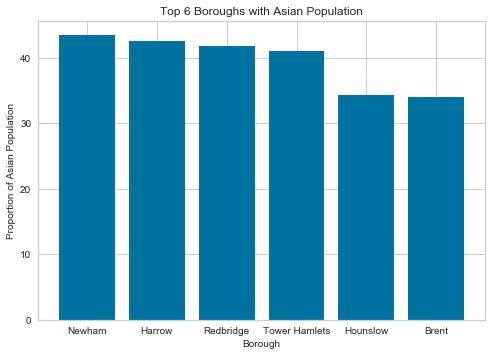

In [53]:
# Importing required library
import matplotlib.pyplot as plt 

asian_top6 = demo_df_sorted.head(6)

# Bar graph of proportion of Asian Population by Neighbourhood
plt.bar(asian_top6['Local authority'], asian_top6['Asian'])
plt.xlabel('Borough', fontsize=10)
plt.ylabel('Proportion of Asian Population', fontsize=10)
plt.title('Top 6 Boroughs with Asian Population')
plt.show()

Now we'll further clean and sort our df to get only the relevant information. By looking at the df.head, we realize that there are some locations where the Postcode are more than one, (like in Albany Park, there are 2 postcodes DA5 and DA14), we'll spread the postcodes to multi-rows and assign the same values from the other columns.

In [13]:
post_df = df.drop('Postcode', axis=1).join(df['Postcode'].str.split(',', expand=True).stack().reset_index(level=1, drop=True).rename('Postcode'))
post_df.head(10)

,Location,Borough,Post town,Dial code,OS grid ref,Postcode
0,Abbey Wood,"Bexley, Greenwich",LONDON,020,TQ465785,SE2
1,Acton,"Ealing, Hammersmith and Fulham",LONDON,020,TQ205805,W3
1,Acton,"Ealing, Hammersmith and Fulham",LONDON,020,TQ205805,W4
2,Addington,Croydon,CROYDON,020,TQ375645,CR0
3,Addiscombe,Croydon,CROYDON,020,TQ345665,CR0
4,Albany Park,Bexley,"BEXLEY, SIDCUP",020,TQ478728,DA5
4,Albany Park,Bexley,"BEXLEY, SIDCUP",020,TQ478728,DA14
5,Aldborough Hatch,Redbridge,ILFORD,020,TQ455895,IG2
6,Aldgate,City,LONDON,020,TQ334813,EC3
7,Aldwych,Westminster,LONDON,020,TQ307810,WC2


Let's drop the 'Dial code' and 'OS grid ref' columns, since we won't need them.

In [14]:
post_df.drop(['Dial code', 'OS grid ref'], axis=1, inplace=True)
post_df.head()

,Location,Borough,Post town,Postcode
0,Abbey Wood,"Bexley, Greenwich",LONDON,SE2
1,Acton,"Ealing, Hammersmith and Fulham",LONDON,W3
1,Acton,"Ealing, Hammersmith and Fulham",LONDON,W4
2,Addington,Croydon,CROYDON,CR0
3,Addiscombe,Croydon,CROYDON,CR0


Now, in the table above, we can see 'Croydon' listed as 'Post town'. Since we're only interested in analyzing neighborhoods purely inside London, we'll create a new dataframe where the 'Post town' values are equal to London only.

In [15]:
post_df.shape

(637, 4)

In [16]:
new_df = post_df[post_df['Post town'].str.contains('LONDON')]
new_df.shape # The new df almost has half as many rows as before

(381, 4)

The new table only contains the rows with London as the 'Post town', so we can drop the 'Post town' column now. Our resulting dataframe consists of 3 columns now.

In [17]:
new_df.drop('Post town', axis=1, inplace=True)
new_df.head()

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\frame.py:4102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,Location,Borough,Postcode
0,Abbey Wood,"Bexley, Greenwich",SE2
1,Acton,"Ealing, Hammersmith and Fulham",W3
1,Acton,"Ealing, Hammersmith and Fulham",W4
6,Aldgate,City,EC3
7,Aldwych,Westminster,WC2


In the demo_df, we filtered out the top 6 boroughs with the most Asian Population. So we can now edit the table above and create a new dataframe to only contain the neighborhoods and their postcodes in the top 6 Boroughs only.

In [18]:
demo_df_sorted['Local authority'].head(6)

24           Newham
13           Harrow
25        Redbridge
29    Tower Hamlets
17         Hounslow
3             Brent
Name: Local authority, dtype: object

In [19]:
df_top6 = new_df[new_df['Borough'].isin(['Newham', 'Harrow', 'Redbridge', 'Tower Hamlets', 'Hounslow', 'Brent'])].reset_index(drop=True)
df_top6.head()

,Location,Borough,Postcode
0,Beckton,Newham,E6
1,Beckton,Newham,E16
2,Beckton,Newham,IG11
3,Bethnal Green,Tower Hamlets,E2
4,Blackwall,Tower Hamlets,E14


### 2.2 Geospatial Data Collection

Now we'll work on the top 6 Boroughs(as per Asian Population) only.  
First, we'll create a get_latlong function to use arcgis_geocoder to extract location coordinates for any location

In [20]:
def get_latlong(arcgis_geocoder):
    
    # Initialize the Location (lat. and long.) to "None"
    lat_lng_coords = None
    
    # While loop helps to create a continous loop until all the location coordinates are gathered
    while(lat_lng_coords is None):
        g = geocoder.arcgis('{}, London, United Kingdom'.format(arcgis_geocoder))
        lat_lng_coords = g.latlng
    return lat_lng_coords

We'll use the get_latlong function to extract location coordinates for the neighborhoods in top 6 boroughs and save them in coord list.

In [21]:
postal_codes = df_top6['Postcode']
coord = [get_latlong(postal_code) for postal_code in postal_codes.tolist()]

Defining df_location to include latitude and longitude columns in the df_top6

In [22]:
df_location = df_top6
df_coord = pd.DataFrame(coord, columns=['Latitude', 'Longitude'])
df_location['Latitude'] = df_coord['Latitude']
df_location['Longitude'] = df_coord['Longitude']

df_location.head()

,Location,Borough,Postcode,Latitude,Longitude
0,Beckton,Newham,E6,51.53292,0.054610
1,Beckton,Newham,E16,51.50913,0.015280
2,Beckton,Newham,IG11,51.53312,0.084077
3,Bethnal Green,Tower Hamlets,E2,51.52669,-0.062570
4,Blackwall,Tower Hamlets,E14,51.51122,-0.012640


## 3. Methodology

### 3.1 Exploratory Data Analysis

We'll now use these coordinates to send venue requests to Foursquare API. First, we'll do it for one of the neighborhoods only, to see if our defined functions to get the foursquare data are working correctly. So we choose 'Blackwall' as a sample to carry out our initial analysis on.

In [23]:
# Resets the current index to a new one
top6_df = df_location.reset_index().drop('index', axis=1)
top6_df.loc[top6_df['Location'] == 'Blackwall']

,Location,Borough,Postcode,Latitude,Longitude
4,Blackwall,Tower Hamlets,E14,51.51122,-0.01264


In [24]:
blackwall_lat = top6_df.loc[4, 'Latitude']
blackwall_long = top6_df.loc[4, 'Longitude']

print('The coordinates for Blackwall are {},{}'.format(blackwall_lat, blackwall_long))

The coordinates for Blackwall are 51.51122000000004,-0.012639999999976226


#### Using Foursquare API for single location

In [25]:
# Foursquare Credentials

CLIENT_ID = 'TJFZA1ML3UOHLHST04BKKOW3CG52IJSKE4L0DFFLEKF00Y0M'
CLIENT_SECRET = 'UEHSR52QJVP4CJQDYROCUVBVASMY5SSJXFEQDWWQZ2CVZVRW'
VERSION = '20200101'
LIMIT = 100 #Because of Foursquare Regular calls limitation
radius = 1000 #setting radius of 1 km

In [26]:
# Defining url to get data from the foursquare api
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, VERSION, blackwall_lat, blackwall_long, radius, LIMIT)
url

'https://api.foursquare.com/v2/venues/explore?&client_id=TJFZA1ML3UOHLHST04BKKOW3CG52IJSKE4L0DFFLEKF00Y0M&client_secret=UEHSR52QJVP4CJQDYROCUVBVASMY5SSJXFEQDWWQZ2CVZVRW&v=20200101&ll=51.51122000000004,-0.012639999999976226&radius=1000&limit=100'

Getting results from the foursquare API and storing them in .json format

In [27]:
results = requests.get(url).json()

We'll define a new function get_category_type to get the categories of the venues returned by Foursquare.

In [28]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

Now we'll use the get_category_type function to find nearby venues to our specified location 'Blackwall'. Then we'll define a new df nearby_venues with their respective category types.

In [29]:
venues = results['response']['groups'][0]['items']
    
nearby_venues = json_normalize(venues) # flatten JSON
# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]
# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)
# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]
nearby_venues.head()

,name,categories,lat,lng
0,Maureen's Pie & Mash Shop,English Restaurant,51.512950,-0.015261
1,Billingsgate Market,Fish Market,51.506312,-0.014184
2,Sichuan Kitchen,Chinese Restaurant,51.511278,-0.011738
3,Crossrail Place Roof Garden,Garden,51.505965,-0.016822
4,Poplar Park,Park,51.509958,-0.016545


Now when we analyze the above table as per the venue categories, we find out that coffee shop is the most common nearby venue in Blackwall.

In [30]:
nearby_venues_blackwall_unique = nearby_venues['categories'].value_counts().to_frame(name='Count')
nearby_venues_blackwall_unique.head(5)

,Count
Coffee Shop,10
Hotel,4
Italian Restaurant,4
Café,4
Sandwich Place,3


#### Using Foursquare API for all the locations (in Top 6 Boroughs)

We have to repeat the above process for Blackwall that we did for all the locations in our top 6 boroughs. So we can define a function 'getNearbyVenues' to repeat the same process of gathering venue data from the foursquare api.

In [31]:
def getNearbyVenues(names, latitudes, longitudes, radius=1000):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

So we define a new dataframe london_venues which contains the location data retrieved from the foursquare API, for all the neighborhoods in our top 6 boroughs.

In [32]:
london_venues = getNearbyVenues(names=top6_df['Location'], latitudes=top6_df['Latitude'], longitudes=top6_df['Longitude'])

Beckton
Beckton
Beckton
Bethnal Green
Blackwall
Bow
Brent Park
Bromley (also Bromley-by-Bow)
Brondesbury
Cambridge Heath
Canary Wharf
Canning Town
Church End
Cubitt Town
Custom House
Dollis Hill
East Ham
Forest Gate
Grove Park
Gunnersbury
Harlesden
Isle of Dogs
Kensal Green
Kensal Green
Kingsbury
Leamouth
Limehouse
Little Ilford
Manor Park
Maryland
Mile End
Millwall
Neasden
Neasden
North Woolwich
Old Ford
Plaistow
Poplar
Queen's Park
Ratcliff
Shadwell
Silvertown
South Woodford
Spitalfields
Stepney
Stonebridge
Stratford
Tower Hill
Upton Park
Upton Park
Wanstead
Wapping
West Ham
West Ham
Whitechapel
Willesden
Woodford
Woodford


In [33]:
london_venues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Beckton,51.53292,0.05461,McDonald's,51.534031,0.053797,Fast Food Restaurant
1,Beckton,51.53292,0.05461,The Miller's Well (Wetherspoon),51.533406,0.056379,Pub
2,Beckton,51.53292,0.05461,Central Park,51.528808,0.052901,Park
3,Beckton,51.53292,0.05461,Costa Coffee,51.534517,0.053365,Coffee Shop
4,Beckton,51.53292,0.05461,Primark,51.535303,0.052308,Clothing Store


We can see that there are 222 unique venue categories in our dataframe.

In [34]:
london_venues_unique = london_venues['Venue Category'].value_counts().to_frame(name='Count')

print('There are {} unique categories.'.format(len(london_venues['Venue Category'].unique())))

There are 222 unique categories.


It'll be convenient if we can visualize how all our relevant locations are distributed over London. To do that, we can create a map using Folium library.  
First we'll get the location coordinates for London using geocode's Nominatim function:

In [35]:
address = 'London, United Kingdom'
geolocator = Nominatim(user_agent="london_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinates of London are {}, {}.'.format(latitude, longitude))

The geograpical coordinates of London are 51.5073219, -0.1276474.


We can now plot the map of London using Folium, and then we'll add all the locations on the London's map using circle markers. The resulting map will show us all our relevant locations as circles on top of London's map. We can easily visualize how our locations are spread across London.

In [36]:
# Plotting Map of London
map_london = folium.Map(location = [latitude, longitude], zoom_start = 11)

# Adding markers to map
for lat, lng, borough, loc in zip(top6_df['Latitude'], 
                                  top6_df['Longitude'],
                                  top6_df['Borough'],
                                  top6_df['Location']):
    label = '{} - {}'.format(loc, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='green',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7).add_to(map_london)  
    
display(map_london)
map_london.save("London's Map with Top 6 Asian neighborhoods.png")



### 3.2 Clustering

#### Unsupervised Learning  
Now that we've gathered and filtered out our relevant data for analysis, we need to extract meaningful information from the data. Since our data is primarily location based, it won't be a good practice to implement 'Regression' or 'Classification' for machine learning. The most appropriate method for this location based data would be 'Clustering'. One of the most widely used clustering techniques is 'K-Means Clustering'. KMeans Clustering is an unsupervised learning technique which can classify our relevant data in K number of clusters, so we can easily extract meaningful information from our clusters.

First we'll use one hot encoding to get venue categories as columns for better analysis

In [37]:
# one hot encoding
london_onehot = pd.get_dummies(london_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
london_onehot['Neighbourhood'] = london_venues['Neighborhood'] 

# move neighbourhood column to the first column
fixed_columns = [london_onehot.columns[-1]] + list(london_onehot.columns[:-1])
london_onehot = london_onehot[fixed_columns]

list(london_onehot.columns)

['Neighbourhood',
 'Accessories Store',
 'American Restaurant',
 'Antique Shop',
 'Arepa Restaurant',
 'Argentinian Restaurant',
 'Art Gallery',
 'Art Museum',
 'Arts & Crafts Store',
 'Asian Restaurant',
 'Athletics & Sports',
 'Auto Garage',
 'BBQ Joint',
 'Bagel Shop',
 'Bakery',
 'Bar',
 'Basketball Court',
 'Beach',
 'Bed & Breakfast',
 'Beer Bar',
 'Beer Store',
 'Bistro',
 'Boat or Ferry',
 'Bookstore',
 'Boutique',
 'Boxing Gym',
 'Brasserie',
 'Brazilian Restaurant',
 'Breakfast Spot',
 'Brewery',
 'Bridal Shop',
 'Bridge',
 'Bubble Tea Shop',
 'Buddhist Temple',
 'Bulgarian Restaurant',
 'Burger Joint',
 'Bus Line',
 'Bus Station',
 'Bus Stop',
 'Cable Car',
 'Café',
 'Canal Lock',
 'Castle',
 'Caucasian Restaurant',
 'Champagne Bar',
 'Chinese Restaurant',
 'Chocolate Shop',
 'Church',
 'Climbing Gym',
 'Clothing Store',
 'Cocktail Bar',
 'Coffee Shop',
 'Colombian Restaurant',
 'Comedy Club',
 'Comfort Food Restaurant',
 'Community College',
 'Construction & Landscaping',
 

When we look at the list of venue categories closely, there's a separate category of 'Indian Restaurant' in the list. At the start of this project, it was described that the criteria for finding a suitable location for a Pakistani restaurant will be to analyze the locations having the most number of 'Asian Restaurants'.   
But now that we looked at the data, it would be much better if we analyze the 'Indian Restaurants' instead of 'Asian Restaurants'. There are two main reasons for this change:  
1. Indian and Pakistani population belong to the same ethnicity within the Asians. Asians as a race consist of various ethnicities (Chinese, Arabs etc.) and choosing Indian Restaurant instead of Asian Restaurant would narrow down and focus our analysis on the similar ethnicity.  
2. Indian and Pakistani cuisines are almost similar. Both the cuisines use almost the same types of spices and the food category 'desi' includes both Indian and Pakistani cuisines because of their similarity. This would help us understand the location data better, since the target audience of the restaurant can be much better analyzed by Indian Restaurant as a criteria rather than Asian Restaurant (could include Chinese cuisines, Thai cuisines etc. which are not similar to Pakistani cuisines).
   
Therefore, its better to focus on 'Indian Restaurants' in our relevant locations to get an understanding of the proportion of the same ethnicity.

In [38]:
london_onehot.loc[london_onehot['Indian Restaurant'] != 0]

,Neighbourhood,Accessories Store,American Restaurant,Antique Shop,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,...,Turkish Restaurant,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio
5,Beckton,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,Beckton,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
243,Bethnal Green,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
254,Blackwall,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
331,Blackwall,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3777,Whitechapel,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3793,Whitechapel,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3807,Whitechapel,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3884,Willesden,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Almost 77 Indian Restaurants exist in all our relevant locations. Now we'll find the average number of venue categories for each neighborhood.

In [39]:
london_grouped = london_onehot.groupby('Neighbourhood').mean().reset_index()
london_grouped.head()

,Neighbourhood,Accessories Store,American Restaurant,Antique Shop,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,...,Turkish Restaurant,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio
0,Beckton,0.0,0.006803,0.0,0.00,0.0,0.000000,0.0,0.0,0.00,...,0.013605,0.00,0.0,0.00,0.006803,0.006803,0.000000,0.0,0.006803,0.00
1,Bethnal Green,0.0,0.000000,0.0,0.01,0.0,0.000000,0.0,0.0,0.00,...,0.010000,0.01,0.0,0.00,0.000000,0.040000,0.000000,0.0,0.010000,0.03
2,Blackwall,0.0,0.000000,0.0,0.00,0.0,0.000000,0.0,0.0,0.02,...,0.000000,0.00,0.0,0.01,0.000000,0.000000,0.000000,0.0,0.000000,0.00
3,Bow,0.0,0.000000,0.0,0.00,0.0,0.026667,0.0,0.0,0.00,...,0.013333,0.00,0.0,0.00,0.000000,0.000000,0.013333,0.0,0.000000,0.00
4,Brent Park,0.0,0.000000,0.0,0.00,0.0,0.000000,0.0,0.0,0.00,...,0.000000,0.00,0.0,0.00,0.032258,0.000000,0.000000,0.0,0.000000,0.00


Using the data from the table above, we can visualize how the Indian Restaurants are distributed across different neighborhoods. To do that, we can sort the table in descending order of the largest mean values of Indian Restaurants, and then plot a bar graph of the top 10 neighborhoods with the highest average number of Indian Restaurants.  
This plot not only tells us the neighborhoods with the most number of Indian Restaurants, but it also explains the population distribution as per ethnicity across different neighborhoods. Recall that initially we used 'Asian' race to find out the best proportion of Asians (which could include Chinese, Arabs etc. as well), but now this graph will give us an indication on which neighborhoods out of those have the highest proportion of Indian (or Pakistani) ethnicity.

Text(0.5, 1.0, 'Top 10 Average Number of Indian Restaurants across different Neighborhoods')

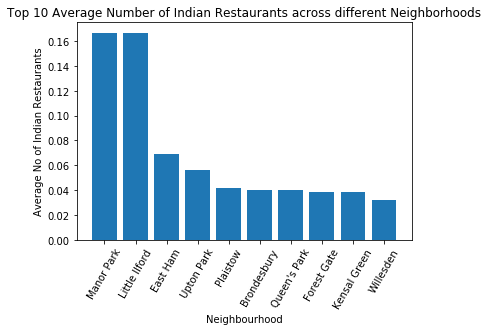

In [40]:
Indian = london_grouped.sort_values(by= 'Indian Restaurant', ascending=False)
Indian = Indian.head(10)
plt.bar(Indian['Neighbourhood'], Indian['Indian Restaurant'])
plt.xlabel('Neighbourhood', fontsize=10)
plt.ylabel('Average No of Indian Restaurants', fontsize=10)
plt.xticks(Indian['Neighbourhood'], fontsize=10, rotation=60)
plt.title('Top 10 Average Number of Indian Restaurants across different Neighborhoods')


From the bar graph, Manor Park and Little Ilford have the most number of Indian Restaurants, which means these locations have a large influx of people from the Indian ethnicity, and would be the ideal place to open a Pakistani restaurant in.  
But we need to further explore the venues across neighborhoods to find the most common venues for each neighborhood.

In [41]:
num_top_venues = 10 # Top common venues needed
for hood in london_grouped['Neighbourhood']:
    print("----"+hood+"----")
    temp = london_grouped[london_grouped['Neighbourhood'] == hood].T.reset_index()
    temp.columns = ['venue', 'freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending = False).reset_index(drop = True).head(num_top_venues))
    print('\n')

----Beckton----
                  venue  freq
0                 Hotel  0.09
1         Grocery Store  0.05
2           Coffee Shop  0.05
3    Chinese Restaurant  0.03
4    Italian Restaurant  0.03
5  Fast Food Restaurant  0.03
6                   Pub  0.03
7                  Park  0.03
8        Sandwich Place  0.03
9           Supermarket  0.03


----Bethnal Green----
                venue  freq
0         Coffee Shop  0.12
1                 Pub  0.09
2                Café  0.08
3          Restaurant  0.05
4  Italian Restaurant  0.04
5        Cocktail Bar  0.04
6            Wine Bar  0.04
7         Yoga Studio  0.03
8                Farm  0.02
9            Beer Bar  0.02


----Blackwall----
                  venue  freq
0           Coffee Shop  0.10
1    Italian Restaurant  0.04
2                  Café  0.04
3                 Hotel  0.04
4                  Park  0.03
5        Sandwich Place  0.03
6  Gym / Fitness Center  0.03
7          Burger Joint  0.03
8                 Plaza  0.03
9 

                   venue  freq
0                    Pub  0.07
1                  Hotel  0.05
2          Grocery Store  0.05
3         Clothing Store  0.03
4                   Café  0.03
5                    Gym  0.02
6     Italian Restaurant  0.02
7              Juice Bar  0.02
8            Coffee Shop  0.02
9  General Entertainment  0.02


----Tower Hill----
                  venue  freq
0                 Hotel  0.11
1  Gym / Fitness Center  0.05
2          Cocktail Bar  0.05
3           Coffee Shop  0.04
4            Restaurant  0.04
5                  Café  0.03
6           Salad Place  0.03
7    English Restaurant  0.03
8     French Restaurant  0.03
9        Scenic Lookout  0.03


----Upton Park----
                  venue  freq
0                   Pub  0.09
1                  Park  0.08
2         Grocery Store  0.08
3  Gym / Fitness Center  0.06
4                  Café  0.06
5     Indian Restaurant  0.06
6  Fast Food Restaurant  0.06
7     Fish & Chips Shop  0.06
8        Clothing

From the data above, it is evident that Pubs, cafes and coffee shops are the most common venues. But we still need to rearrange this data to make it easily readable and to better understand the most common venues in each neighborhood.

In [42]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending = False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [43]:
num_top_venues = 10
indicators = ['st', 'nd', 'rd']
# create columns according to number of top venues
columns = ['Neighbourhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))
# create a new dataframe
neighbourhoods_venues_sorted = pd.DataFrame(columns=columns)
neighbourhoods_venues_sorted['Neighbourhood'] = london_grouped['Neighbourhood']
for ind in np.arange(london_grouped.shape[0]):
    neighbourhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(london_grouped.iloc[ind, :], num_top_venues)
neighbourhoods_venues_sorted.head(5)

,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Beckton,Hotel,Grocery Store,Coffee Shop,Pub,Sandwich Place,Supermarket,Fast Food Restaurant,Pizza Place,Chinese Restaurant,Park
1,Bethnal Green,Coffee Shop,Pub,Café,Restaurant,Cocktail Bar,Wine Bar,Italian Restaurant,Yoga Studio,Chocolate Shop,Pilates Studio
2,Blackwall,Coffee Shop,Café,Italian Restaurant,Hotel,Park,Burger Joint,Sandwich Place,Plaza,Gym / Fitness Center,Bakery
3,Bow,Pub,Coffee Shop,Café,Grocery Store,Pizza Place,Bar,Convenience Store,Fast Food Restaurant,Art Gallery,Bus Stop
4,Brent Park,Platform,Grocery Store,Park,Pub,Plaza,Bus Stop,Brazilian Restaurant,Convenience Store,Middle Eastern Restaurant,Bus Line


Now to make clusters using KMeans Clustering, we'll drop the 'Neighbourhood' column, so we can apply clustering on the top 10 most common venues for each neighborhood.

In [44]:
london_clustering = london_grouped.drop('Neighbourhood', 1)

One of the integral parts of KMeans Clustering is to choose an appropriate number of K (number of clusters). To ease up this task, we used KElbowVisualizer which can easily iterate values of K and use the elbow method to identify the most appropriate K (in our case, it comes out to be k = 4). This essentially means that our clusters will be best defined if the number of clusters is equal to 4. 

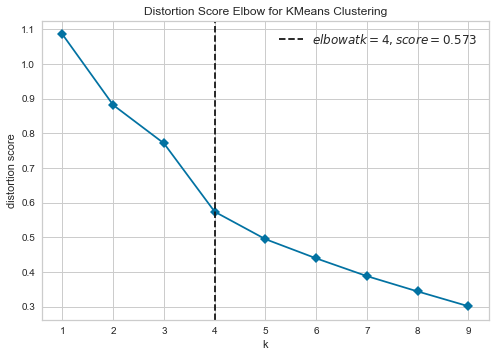

In [54]:
!pip install yellowbrick
from yellowbrick.cluster import KElbowVisualizer

# Instantiate the clustering model and visualizer
model = KMeans()
visualizer = KElbowVisualizer(model, k=(1,10), timings=False)

visualizer.fit(london_clustering)        # Fit the data to the visualizer
visualizer.show() 
    

So we set the number of clusters to 4 and fit our data accordingly. This divides all the neighborhoods into clusters using Kmeans clustering technique.

In [46]:
# set number of clusters
kclusters = 4
# run k-means clustering
kmeans = KMeans(n_clusters = kclusters, random_state=0).fit(london_clustering)
# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([1, 2, 1, 2, 0, 2, 2, 2, 1, 1])

To be able to understand the clustering better, we can join the cluster labels to our neighborhoods dataframe and define a new dataframe london_merged containing the location and venue information as well the cluster labels.

In [47]:
# add clustering labels
neighbourhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)
london_merged = top6_df
# match/merge London data with latitude/longitude for each neighborhood
london_merged = london_merged.join(neighbourhoods_venues_sorted.set_index('Neighbourhood'), on = 'Location')
london_merged.head()

,Location,Borough,Postcode,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Beckton,Newham,E6,51.53292,0.054610,1,Hotel,Grocery Store,Coffee Shop,Pub,Sandwich Place,Supermarket,Fast Food Restaurant,Pizza Place,Chinese Restaurant,Park
1,Beckton,Newham,E16,51.50913,0.015280,1,Hotel,Grocery Store,Coffee Shop,Pub,Sandwich Place,Supermarket,Fast Food Restaurant,Pizza Place,Chinese Restaurant,Park
2,Beckton,Newham,IG11,51.53312,0.084077,1,Hotel,Grocery Store,Coffee Shop,Pub,Sandwich Place,Supermarket,Fast Food Restaurant,Pizza Place,Chinese Restaurant,Park
3,Bethnal Green,Tower Hamlets,E2,51.52669,-0.062570,2,Coffee Shop,Pub,Café,Restaurant,Cocktail Bar,Wine Bar,Italian Restaurant,Yoga Studio,Chocolate Shop,Pilates Studio
4,Blackwall,Tower Hamlets,E14,51.51122,-0.012640,1,Coffee Shop,Café,Italian Restaurant,Hotel,Park,Burger Joint,Sandwich Place,Plaza,Gym / Fitness Center,Bakery


Now that the clusters are defined. We can use the cluster labels to define clusters on a map and colour code them to easily visualize how the clusters are formed.

In [55]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(london_merged['Latitude'], london_merged['Longitude'], london_merged['Location'], london_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=10,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

We can now define the four clusters and display them in separate tables to get a better understanding of which clusters contain which neighborhoods and the most common venues across clusters.

In [49]:
Cluster_1 = london_merged.loc[london_merged['Cluster Labels'] == 0,
                              london_merged.columns[[0] + list(range(5, london_merged.shape[1]))]]
Cluster_1

,Location,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
6,Brent Park,0,Platform,Grocery Store,Park,Pub,Plaza,Bus Stop,Brazilian Restaurant,Convenience Store,Middle Eastern Restaurant,Bus Line
12,Church End,0,Platform,Grocery Store,Park,Pub,Plaza,Bus Stop,Brazilian Restaurant,Convenience Store,Middle Eastern Restaurant,Bus Line
20,Harlesden,0,Platform,Grocery Store,Park,Pub,Plaza,Bus Stop,Brazilian Restaurant,Convenience Store,Middle Eastern Restaurant,Bus Line
32,Neasden,0,Grocery Store,Platform,Warehouse Store,Pub,Hotel,Furniture / Home Store,Fast Food Restaurant,Park,Coffee Shop,Bus Station
33,Neasden,0,Grocery Store,Platform,Warehouse Store,Pub,Hotel,Furniture / Home Store,Fast Food Restaurant,Park,Coffee Shop,Bus Station
45,Stonebridge,0,Platform,Grocery Store,Park,Pub,Plaza,Bus Stop,Brazilian Restaurant,Convenience Store,Middle Eastern Restaurant,Bus Line
55,Willesden,0,Platform,Grocery Store,Park,Pub,Plaza,Bus Stop,Brazilian Restaurant,Convenience Store,Middle Eastern Restaurant,Bus Line


In [50]:
Cluster_2 = london_merged.loc[london_merged['Cluster Labels'] == 1,
                              london_merged.columns[[0] + list(range(5, london_merged.shape[1]))]]
Cluster_2

,Location,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Beckton,1,Hotel,Grocery Store,Coffee Shop,Pub,Sandwich Place,Supermarket,Fast Food Restaurant,Pizza Place,Chinese Restaurant,Park
1,Beckton,1,Hotel,Grocery Store,Coffee Shop,Pub,Sandwich Place,Supermarket,Fast Food Restaurant,Pizza Place,Chinese Restaurant,Park
2,Beckton,1,Hotel,Grocery Store,Coffee Shop,Pub,Sandwich Place,Supermarket,Fast Food Restaurant,Pizza Place,Chinese Restaurant,Park
4,Blackwall,1,Coffee Shop,Café,Italian Restaurant,Hotel,Park,Burger Joint,Sandwich Place,Plaza,Gym / Fitness Center,Bakery
10,Canary Wharf,1,Coffee Shop,Café,Italian Restaurant,Hotel,Park,Burger Joint,Sandwich Place,Plaza,Gym / Fitness Center,Bakery
11,Canning Town,1,Hotel,Italian Restaurant,Coffee Shop,Grocery Store,Light Rail Station,Platform,Café,Hotel Bar,Boat or Ferry,Gym
13,Cubitt Town,1,Coffee Shop,Café,Italian Restaurant,Hotel,Park,Burger Joint,Sandwich Place,Plaza,Gym / Fitness Center,Bakery
14,Custom House,1,Hotel,Italian Restaurant,Coffee Shop,Grocery Store,Light Rail Station,Platform,Café,Hotel Bar,Boat or Ferry,Gym
21,Isle of Dogs,1,Coffee Shop,Café,Italian Restaurant,Hotel,Park,Burger Joint,Sandwich Place,Plaza,Gym / Fitness Center,Bakery
24,Kingsbury,1,Hookah Bar,Asian Restaurant,Supermarket,Platform,Pet Store,Coffee Shop,Pub,Clothing Store,Outdoor Supply Store,Office


In [51]:
Cluster_3 = london_merged.loc[london_merged['Cluster Labels'] == 2,
                              london_merged.columns[[0] + list(range(5, london_merged.shape[1]))]]
Cluster_3

,Location,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
3,Bethnal Green,2,Coffee Shop,Pub,Café,Restaurant,Cocktail Bar,Wine Bar,Italian Restaurant,Yoga Studio,Chocolate Shop,Pilates Studio
5,Bow,2,Pub,Coffee Shop,Café,Grocery Store,Pizza Place,Bar,Convenience Store,Fast Food Restaurant,Art Gallery,Bus Stop
7,Bromley (also Bromley-by-Bow),2,Pub,Coffee Shop,Café,Grocery Store,Pizza Place,Bar,Convenience Store,Fast Food Restaurant,Art Gallery,Bus Stop
8,Brondesbury,2,Coffee Shop,Pub,Grocery Store,Indian Restaurant,Café,Bakery,Italian Restaurant,Thai Restaurant,Bar,Gym / Fitness Center
9,Cambridge Heath,2,Coffee Shop,Pub,Café,Restaurant,Cocktail Bar,Wine Bar,Italian Restaurant,Yoga Studio,Chocolate Shop,Pilates Studio
15,Dollis Hill,2,Grocery Store,Warehouse Store,Furniture / Home Store,Gym / Fitness Center,Hotel,Fast Food Restaurant,Coffee Shop,Pub,Chinese Restaurant,Electronics Store
16,East Ham,2,Fast Food Restaurant,Clothing Store,Grocery Store,Indian Restaurant,Sandwich Place,Pub,Park,Coffee Shop,Sporting Goods Shop,Bus Station
17,Forest Gate,2,Grocery Store,Pub,Café,Fast Food Restaurant,Bus Stop,Hotel,Gym,Soccer Stadium,Flower Shop,Market
18,Grove Park,2,Pub,Café,Coffee Shop,Bakery,Park,French Restaurant,Burger Joint,Ice Cream Shop,Sushi Restaurant,Italian Restaurant
19,Gunnersbury,2,Pub,Café,Coffee Shop,Bakery,Park,French Restaurant,Burger Joint,Ice Cream Shop,Sushi Restaurant,Italian Restaurant


In [52]:
Cluster_4 = london_merged.loc[london_merged['Cluster Labels'] == 3,
                              london_merged.columns[[0] + list(range(5, london_merged.shape[1]))]]
Cluster_4

,Location,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
27,Little Ilford,3,Restaurant,Gym / Fitness Center,Indian Restaurant,Gas Station,Auto Garage,Pub,Park,Hotel,Train Station,Entertainment Service
28,Manor Park,3,Restaurant,Gym / Fitness Center,Indian Restaurant,Gas Station,Auto Garage,Pub,Park,Hotel,Train Station,Entertainment Service


## 4. Results

From the clusters above, we can deduce the following results:
1. Cluster 4 has the most number of Indian Restaurants and would be the most suitable for opening up a Pakistani Restaurant. It contains only two neighborhoods (Little Ilford and Manor Park). So Little Ilford and Manor Park will be the ideal locations for a Pakistani Restaurant. Both these neighborhoods have the Indian Restaurants as the 3rd most common venue, which is good indication of the presence of Indian ethnic population in the area and hence the largest customer base of the same ethnicity.  
2. Cluster 3 also contains multiple neighborhoods with Indian Restaurants as the 4th or 5th most common venue. The neighborhoods of Queen's Park, Upton Park, Kensal Green, Eastham and Brondesbury have a good number of Indian restaurants and can be considered as viable locations for a Pakistani restaurant.  
3. Cluster 1 and 2 have insignificant number of Indian Restaurants, which is an indication that the population in these neighborhoods in these clusters may belong to other Asian ethnicites (Chinese, Arabs etc.) and the customer base of Indian ethnicity would not be enough. 

## 5. Discussion and Recommendations

When we look at the bigger picture, all the neighborhoods with the most number of Indian restaurants are within the boroughs of Newham and Brent. So it is understood that the Pakistani restaurant has to be within these boroughs to have a significant customer base.
Little Ilford and Manor Park are the most suitable locations to open up a Pakistani restaurant. However, both these neighborhoods already have a lot of Indian restaurants so the competition will be a lot and it'll be really difficult to compete with the large number of options already available to the customers there.  
Queen's Park, Upton Park, Kensal Green and Brondsbury (all in Brent borough) present a good option and the number of Indian Restaurants there are less than in Little Ilford and Manor Park locations, so the competition will be lesser. However this can also imply that the customers of Indian ethnicity are less likely to come to Brent than Newham (which contains Little Ilford and Manor Park neighborhoods). Therefore the decision of opening up a Pakistani restaurant there is quite risky.  
**Eastham** (located in Newham) does not have many Indian Restaurants (4th most common venue) so the competition will be lesser than in Little Ilford and Manor Park, and it is located in close vicinity of Little Ilford and Manor Park (as shown on the map) which means that it can possibly attract the customers from Little Ilford and Manor Park (biggest influx of customers of Indian ethnicity). Moreover Eastham contains a good amount of shopping places (clothing shops and grocery stores) as well as bus stations, which means that it can target a bigger audience than any other neighborhoods and still have a less competitive market than in Little Ilford and Manor Park. Therefore **Eastham** is the most suitable location for a new Pakistani restaurant.

## 6. Conclusion

Eastham is recommended as the most suitable location for opening up a Pakistani restaurant after the data analysis. However there are various other factors that should be considered before making a business decision. The property rents, ease of access, traffic situation and the market structure all play an important role in the success of a restaurant and these need to be considered as well before making a final decision.  
In this analysis, a few limitations such as the limitation of venues for exploration in Foursquare's developer account and unavailability of the data related to costs might have affected our analysis and the availability of such data may lead to more accurate and practical results. Also there was no demographic data available for locations based on ethnicity. We analyzed the neighborhoods with the most proportion of Asian population but the Asian population contains people from other ethnicities as well such as Chinese or Arabs, which are irrelevant to our analysis and might have caused inaccuracies. We can get better results if we have the data for Indian ethnicity (or specifically for Pakistani population) and we can make better recommendations based on that data.  